In [1]:
import xarray as xr
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import boto3
from botocore.config import Config

my_config = Config(
    region_name = 'us-west-2',
    signature_version = 'v4',
    retries = {
        'max_attempts': 10,
        'mode': 'standard'
    }
)

Need to set the default AWS zone to us-west-2

1. setup ~/.aws/config

    [default]
    
    region=us-west-2

2. set environment variable:

    - export AWS_DEFAULT_REGION=us-west-2

I did both, and it worked. 


Note, for specific uses, you can set the region manually. But, it seems that earthaccess uses the default boto3 configs.

- boto3.client('s3', config=my_config).meta.region_name


In [3]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S')

### us-west-2 Region Check: &#x2705;

In [4]:
# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

# Search for the granule by DOI
results = earthaccess.search_data(
    doi='10.5067/VJAFPLI1CSIV',
    temporal=("2019-03-13", "2019-03-13"),
)

In [5]:
results

[Collection: {'ShortName': 'M2T1NXSLV', 'Version': '5.12.4'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2019-03-13T00:00:00.000Z', 'EndingDateTime': '2019-03-13T23:59:59.000Z'}}
 Size(MB): 395.843297958374
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4']]

In [18]:
fn = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
ds = xr.open_mfdataset(fn)

In [21]:
type(ds.SLP)

xarray.core.dataarray.DataArray

In [24]:
ds.SLP.size

4990464

In [25]:
ds.SLP

<xarray.DataArray 'SLP' (time: 24, lat: 361, lon: 576)> Size: 20MB
dask.array<open_dataset-SLP, shape=(24, 361, 576), dtype=float32, chunksize=(1, 91, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 192B 2019-03-13T00:30:00 ... 2019-03-13T23...
Attributes:
    long_name:       sea_level_pressure
    units:           Pa
    fmissing_value:  1000000000000000.0
    standard_name:   sea_level_pressure
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [26]:
ds.SLP[15,:,:]

<xarray.DataArray 'SLP' (lat: 361, lon: 576)> Size: 832kB
dask.array<getitem, shape=(361, 576), dtype=float32, chunksize=(91, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    time     datetime64[ns] 8B 2019-03-13T15:30:00
Attributes:
    long_name:       sea_level_pressure
    units:           Pa
    fmissing_value:  1000000000000000.0
    standard_name:   sea_level_pressure
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [30]:
# Subset SLP at 15:30Z, convert units
slp = ds.SLP[15,:,:] / 100 # convert to hPa
slp = slp.values

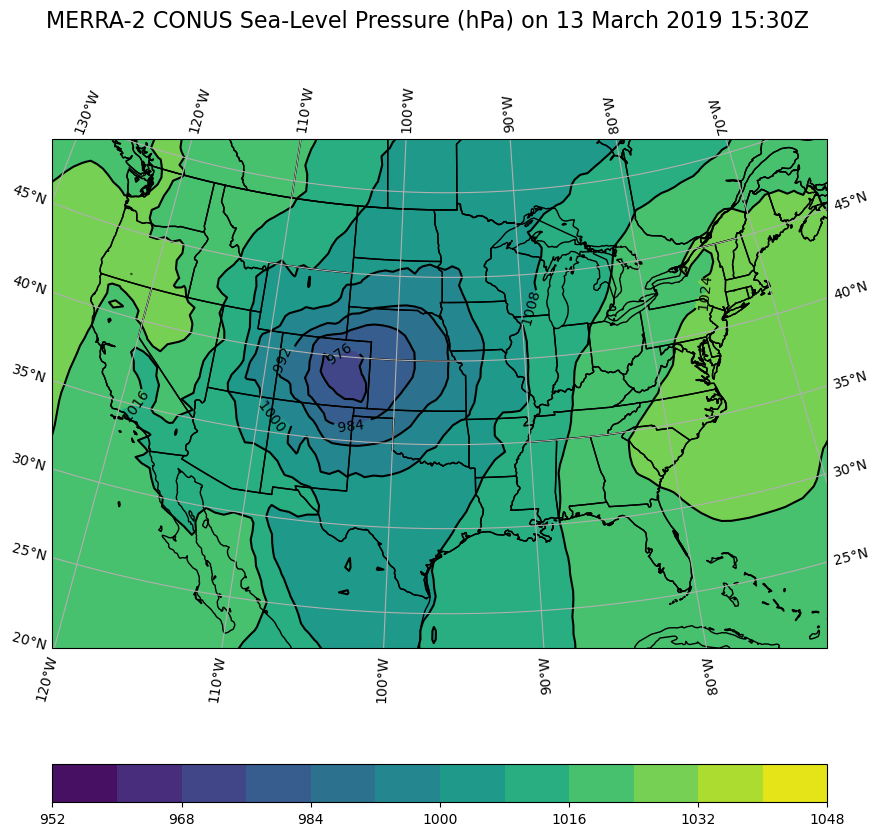

In [31]:
plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Lat/lon grid lines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  
    inline=True,  
    fmt=' {:.0f} '.format,  
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z', fontsize=16)

plt.show()

In [32]:
ds.attrs

{'History': 'Original file generated: Sat Mar 23 22:40:03 2019 GMT',
 'Comment': 'GMAO filename: d5124_m2_jan10.tavg1_2d_slv_Nx.20190313.nc4',
 'Filename': 'MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4',
 'Conventions': 'CF-1',
 'Institution': 'NASA Global Modeling and Assimilation Office',
 'References': 'http://gmao.gsfc.nasa.gov',
 'Format': 'NetCDF-4/HDF-5',
 'SpatialCoverage': 'global',
 'VersionID': '5.12.4',
 'TemporalRange': '1980-01-01 -> 2016-12-31',
 'identifier_product_doi_authority': 'http://dx.doi.org/',
 'ShortName': 'M2T1NXSLV',
 'GranuleID': 'MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4',
 'ProductionDateTime': 'Original file generated: Sat Mar 23 22:40:03 2019 GMT',
 'LongName': 'MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics',
 'Title': 'MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics',
 'SouthernmostLatitude': '-90.0',
 'NorthernmostLatitude': '90.0',
 'WesternmostLongit